In [1]:
from __future__ import print_function, unicode_literals, division
from bz2 import BZ2File
import time
import plac
import ujson
from spacy.matcher import PhraseMatcher
import spacy
import time 
import gc
from spacy import displacy
import numpy as np
import pandas as pd
import os

# 1. Load Data


## 1.1 Inaugural speech
All the Inaugural speeches are store in a dicitonary. Keys are the title and values are the whole text.

In [4]:
speechpath=os.path.expanduser("~Wesle\Documents\GitHub\ADS_Teaching\Projects_StarterCodes\Project1-RNotebook\data\InauguralSpeeches")
speechpath=os.path.normpath(speechpath)

In [5]:
assert os.path.exists(speechpath)
# get the file names in the dir
filenames = os.listdir(speechpath)
# load all speeches in a dictionary
speechdict=dict()
for file in filenames:
    thispath= speechpath + "\\"+file
    with open(thispath,"br") as f:
        thisspeech=f.read().decode("utf-8")
        speechdict[file]=thisspeech

In [6]:
speechpath1=os.path.expanduser("~Wesle\Documents\GitHub\ADS_Teaching\Projects_StarterCodes\Project1-RNotebook\data")
speechpath1=os.path.normpath(speechpath1)
speechinfo=pd.read_excel(speechpath1+"//"+"InaugurationInfo.xlsx")



In [7]:
speechdate=pd.read_table(speechpath1+"//"+"InauguationDates.txt",sep="\t")
speechdate=speechdate.rename(index=str, columns={"PRESIDENT":"President","FIRST": 1, "SECOND":2,"THIRD":3 ,"FOURTH":4})
speechdate=pd.melt(speechdate,id_vars=["President"],value_vars=[1,2,3,4])
speechdate=speechdate.loc[speechdate.value.notnull()]
speechdate=speechdate.rename(index=str,columns={"variable":"Term","value":"date"})


In [8]:
mergeddata=pd.merge(speechinfo, speechdate, on=['President',"Term"], how='left')
# mergeddata.replace(np.nan,"",regex=True)
mergeddata=mergeddata.set_index(["President"])
mergeddata[0:10]

,File,Term,Party,Words,date
President,,,,,
George Washington,GeorgeWashington,1,NaN,1431,4/30/1789
George Washington,GeorgeWashington,2,NaN,135,3/4/1793
John Adams,JohnAdams,1,Fedralist,2321,3/4/1797
Thomas Jefferson,ThomasJefferson,1,Democratic-Republican Party,1730,3/4/1801
Thomas Jefferson,ThomasJefferson,2,Democratic-Republican Party,2166,3/4/1805
James Madison,JamesMadison,1,Democratic-Republican Party,1177,3/4/1809
James Madison,JamesMadison,2,Democratic-Republican Party,1211,3/4/1813
James Monroe,JamesMonroe,1,Democratic-Republican Party,3375,3/4/1817
James Monroe,JamesMonroe,2,Democratic-Republican Party,4472,3/5/1821


## 1.2 Chopus
There are 5 external chopus that will be used in this project. <br>
Sources are listed below
###  en_core_web_sm  (The built-in chopus of spacy )
English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS tags, dependency parse and named entities.
<br>
https://spacy.io/models/en#en_core_web_sm

### CET 4 & CET 6 :

In [9]:
cet4path=os.path.expanduser("~Wesle\Documents\GitHub\ADS_Teaching\Projects_StarterCodes\Project1-RNotebook\data\cet-4.txt")
cet4path=os.path.normpath(cet4path)
assert os.path.exists(cet4path)    
cet4=pd.read_table(cet4path)
def get_string(thislist):
    return thislist[1]
cet4=cet4.iloc[:,0].str.split('"').apply(get_string)
# cet4s=" ".join(list(cet4.values))
# prossessedcet4=FileProcessor(cet4s)
# CET4set=set(prossessedcet4.SelectQualified().text)

In [10]:
cet6path=os.path.expanduser("~Wesle\Documents\GitHub\ADS_Teaching\Projects_StarterCodes\Project1-RNotebook\data\cet-6.txt")
cet6path=os.path.normpath(cet6path)
cet6=pd.read_table(cet6path)
def get_string(thislist):
    return thislist[1]
cet6=cet6.iloc[:,0].str.split('"').apply(get_string)

### TOEFL & GRE :

In [11]:
path=os.path.expanduser("~Wesle\Documents\GitHub\ADS_Teaching\Projects_StarterCodes\Project1-RNotebook\data")
toefl=path+"//"+"TOEFL.txt"
GRE=path+"//"+"GRE.txt"
with open(GRE,"br") as f:
    a=f.read().decode("utf-8")
GRE=a.split("\r\n")
GRE = filter(None, GRE)
GRE=list(GRE)
GRE=[word.replace("\xa0","")for word in GRE]
GRE=[word.replace("\ufeff","")for word in GRE]

In [12]:
with open(toefl,"br") as f:
    a=f.read().decode("utf-8")
    TOEFL=a.split("\r\n")
# print(len(TOEFL))
TOEFL = filter(None, TOEFL)
TOEFL=list(TOEFL)
# print(len(TOEFL))
TOEFL=[word.replace("\xa0","")for word in TOEFL]
TOEFL=[word.replace(" ","")for word in TOEFL]

Since thoses lists have overlap, we have to make each word set disjoint by exluding the low-level words form high level word lists
The suggested rank of word list are as follows:
CET4 < CET6 < TOEFL < GRE

In [13]:
GREset   =set(GRE)-set(TOEFL)-set(cet6)-set(cet4)
TOEFLset =set(TOEFL)-set(cet6)-set(cet4)
CET6set  =set(cet6)-set(cet4)
CET4set  =set(cet4)

### Wiki- 100000: 
https://gist.github.com/h3xx/1976236/revisions
 This is a list of the top 100,000 m It was compiled in August 2005 and

In [14]:
wikipath=os.path.expanduser("~Wesle\Documents\GitHub\google-10000-english\wiki-100k.txt")
wikipath=os.path.normpath(wikipath)
assert os.path.exists(wikipath)
wiki100k=pd.read_table(wikipath,header= None)
wiki100k.drop(wiki100k.index[:26], inplace=True) # the first 26 are empty string 
wiki100k=wiki100k.iloc[:,0].unique() # get rid of replicate

In [15]:
len(set(wiki100k))

84400

## 1.3 word number

In [16]:
corpusdf=pd.DataFrame([[len(CET4set),"CET4"],[len(CET6set),"CET6"],[len(TOEFLset),"TOEFL"],[len(GREset),"GRE"],[len(wiki100k),"wiki"]],columns=["length","name"])

In [17]:
corpusdf

,length,name
0,4434,CET4
1,1123,CET6
2,1459,TOEFL
3,5525,GRE
4,84400,wiki


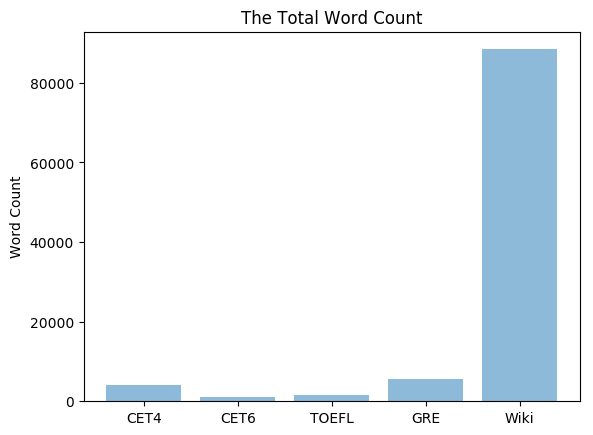

In [18]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('CET4', 'CET6', 'TOEFL', 'GRE', 'Wiki')
y_pos = np.arange(len(objects))
performance = [4126,1123,1459,5525,88401]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Word Count')
plt.title('The Total Word Count')
plt.show()


# 2 Parsing and tokenization using spacy

## 2.1 token & word & word Chunks 


In [19]:
nlp=spacy.load("en")
class FileProcessor():
   
    
    ''' we need pandas,spacy to function'''
    def __init__(self,name,text):
        self.docname=name
        self.doc=nlp(text)
        self.wordnum=len(self.doc)
        self.trivnum=len(self.doc)-len(self.SelectQualified())
        
    def GetTokenDF(self):
        """we want to get the whole dataframe with token details with the help of pandas """
        tokendf=pd.DataFrame(columns=["text","lemma","pos","tag","dep","is_stop"])
        for token in self.doc:
            tokendf.loc[token.text]=[token.text, token.lemma_ ,token.pos_, token.tag_, token.dep_, token.is_stop]
        return tokendf
    
    def SelectQualified(self):
        """this is to select qualified words display in dataframe"""
        tokendf=self.GetTokenDF()
        sampleset=["PROPN","NOUN","VERB","ADJ","ADV"] # pick only noun verb adj and adv words
        Qtoken=tokendf.loc[(tokendf.pos.isin(sampleset))& (tokendf.is_stop == False)] # is_stop  means the trivial words "of the a" 
        return Qtoken
    
    def GetEntityDF(self):
        """get entity data frame excluding cardinal and ordinal"""
        entitydf=pd.DataFrame(columns="text,start_char,end_char,label".split(","))
        for ent in self.doc.ents:
            entitydf.loc[ent.text]=[ent.text, ent.start_char, ent.end_char, ent.label_]
            entitydf=entitydf.loc[(entitydf.label!="CARDINAL") & (entitydf.label!="ORDINAL")] # cardinal and ordinal are not what we want
        return entitydf
    
    def GetWordChunkDF(self):
        """get word chunk  dataframe"""
        samplechunk=pd.DataFrame(columns="text, root.text, root.dep_,head.text".split(","))
        for chunk in self.doc.noun_chunks:
            samplechunk.loc[chunk.text]=[chunk.text, chunk.root.text, chunk.root.dep_,chunk.root.head.text]
        return samplechunk
       
    def GetAvgDepth(self):
        
        def getdepth(token):
             # if right child exist search right child
            if not list(token.children):
                return 0
            else:
                leftmax= 0 if not list(token.lefts) else max([getdepth(i)  for i in token.lefts])
            # if left child exist search leftchild
                rightmax=0  if not list(token.rights) else max([getdepth(i)  for i in token.rights])
                return max(leftmax,rightmax)+1
            # if not child return 0
            # return the max number
        count=0
        mydepth=dict()
        for token in self.doc:
            if token.dep_=="ROOT":
                # iterating each dep and get the depth
                count=count+1
                mydepth[count]=getdepth(token)
        return(sum(mydepth.values())/count)
    def GetAvgSenlen(self):
        sentences = [sent.string.strip() for sent in self.doc.sents]
        return len(self.doc)/len(sentences)
    
    def Getall(self):
        return pd.DataFrame([[self.wordnum,self.trivnum,len(self.GetEntityDF()),len(self.GetWordChunkDF()),self.GetAvgDepth(),self.GetAvgSenlen()]],\
                            columns=["Total words","Trivial words","entities","wordchunk","AvgDepth","AvgLen"],index=[self.docname]) 
    
        
        

In [20]:
samplespeech=speechdict[list(speechdict.keys())[0]]

In [21]:
prossessor=FileProcessor(list(speechdict.keys())[0],samplespeech) # build a file processor

In [22]:
prossessor.Getall()

,Total words,Trivial words,entities,wordchunk,AvgDepth,AvgLen
inaugAbrahamLincoln-1.txt,4027,3162,40,586,6.157895,30.278195


# 3 Matching and dictionary annotation

In [23]:
class WordCount():

    def __init__(self):
        #cet 4 build dictionary check
        cet4matcher =PhraseMatcher(nlp.vocab)
        patterns4=[nlp(text) for text in CET4set]
        cet4matcher.add('cet4', None, *patterns4)
        self.cet4matcher=cet4matcher 
        
        #cet 6 build dictionary check
        matcher6=PhraseMatcher(nlp.vocab)
        patterns6=[nlp(text) for text in CET6set]
        matcher6.add('cet6', None, *patterns6)
        self.cet6matcher=matcher6 
        
        # toefl matcher
        matchertoefl=PhraseMatcher(nlp.vocab)
        patternstoefl=[nlp(text) for text in TOEFLset]
        matchertoefl.add('teofl', None, *patternstoefl)
        self.toeflmatcher= matchertoefl
        
        # gre matcher
        matcherGRE=PhraseMatcher(nlp.vocab)
        patternsGRE=[nlp(text) for text in GREset]
        matchertoefl.add('teofl', None, *patternsGRE)
        self.grematcher= matcherGRE
          
    def get_cet4(self,doc):
        return(len(self.cet4matcher(doc)))
    
    def get_cet6(self,doc):
        return(len(self.cet6matcher(doc)))
    
    def get_gre(self,doc):
        return(len(self.grematcher(doc)))
    
    def get_toefl(self,doc):
        return(len(self.toeflmatcher(doc)))  
#     def get_all()
    def get_cet6_loc(self,doc):
        return self.cet6matcher(doc)
    def get_toefl_loc(self,doc):
        return self.toeflmatcher(doc)
    

In [24]:
%%time
wordcount=WordCount()

Wall time: 3min 46s


In [25]:
samplename=list(speechdict.keys())[0]

In [26]:
sampleprocessor=FileProcessor(samplename,samplespeech)

In [27]:
wordcount.get_cet4(sampleprocessor.doc)

2646

In [28]:
wordcount.get_cet6(sampleprocessor.doc)

52

In [29]:
wordcount.get_gre(sampleprocessor.doc)

0

# 4  Word Complexity Scoring System


In [30]:
class ScoreGrader():
    def __init__(self,freqlist):
        score=dict()
        for i in range(len(freqlist)):
            score[freqlist[i]]=i
        self.scoreboard=score
        
    def get_score(self,df):
        """input is the data frame """
        thisscore=0
        not_recognized=-1
        view=dict()
        for i in range(len(df)):
            try:
                thisscore=thisscore+self.scoreboard[df.iloc[i,1]]
            except KeyError as e:
                not_recognized = not_recognized+1
                view[not_recognized]=str(df.iloc[i,1])
                
        return thisscore

In [31]:
thisgrader=ScoreGrader(wiki100k)
# len(google1w)

In [32]:
thisgrader.get_score(sampleprocessor.SelectQualified())

5495703

# for all speeches

In [33]:
# load the model
nlp=spacy.load("en")

In [34]:
%%time
#get a wordcount
wordcount=WordCount()

Wall time: 3min 55s


In [39]:
%%time
# get a grader
grader=ScoreGrader(wiki100k)

Wall time: 37.3 ms


In [40]:

grammainfo=pd.DataFrame(columns=["Total words","Trivial words","entities","wordchunk","AvgDepth","AvgLen"]) # store the information 
wordcountinfo=pd.DataFrame(columns=["cet4","cet6","toefl","GRE","score"]) # store for word count


for docname,text in speechdict.items():
    thisprocessor=FileProcessor(docname,text) # each file need a specific word processor
    grammainfo=grammainfo.append(thisprocessor.Getall())
    doc=thisprocessor.doc
    Qwords=thisprocessor.SelectQualified()
    wordcountinfo.loc[docname]=[wordcount.get_cet4(doc),wordcount.get_cet6(doc),wordcount.get_toefl(doc),wordcount.get_gre(doc),grader.get_score(Qwords)]



In [41]:
wordcountinfo[1:10]

,cet4,cet6,toefl,GRE,score
inaugAbrahamLincoln-2.txt,497,11,18,0,1316541
inaugAndrewJackson-1.txt,828,17,48,0,2775294
inaugAndrewJackson-2.txt,852,11,34,0,2248573
inaugBarackObama-1.txt,1756,18,35,0,4379315
inaugBarackObama-2.txt,1552,21,42,0,3756031
inaugBenjaminHarrison-1.txt,3161,49,120,0,8689641
inaugCalvinCoolidge-1.txt,2929,55,100,0,6819082
inaugDonaldJTrump-1.txt,1033,7,19,0,2265206
inaugDwightDEisenhower-1.txt,1809,38,61,0,5115561


In [42]:
grammainfo[1:10]

,Total words,Trivial words,entities,wordchunk,AvgDepth,AvgLen
inaugAbrahamLincoln-2.txt,782,557,10,121,5.730769,30.076923
inaugAndrewJackson-1.txt,1215,803,12,252,8.615385,46.730769
inaugAndrewJackson-2.txt,1276,910,12,255,8.258065,41.161290
inaugBarackObama-1.txt,2709,1955,40,478,5.285714,22.764706
inaugBarackObama-2.txt,2362,1713,33,427,5.946237,25.397849
inaugBenjaminHarrison-1.txt,4748,3597,50,863,6.917722,30.050633
inaugCalvinCoolidge-1.txt,4442,3418,28,738,5.739796,22.663265
inaugDonaldJTrump-1.txt,1708,1275,25,285,3.929293,17.252525
inaugDwightDEisenhower-1.txt,2763,2025,38,543,5.446154,21.253846


In [43]:
mergeddata[0:10]

,File,Term,Party,Words,date
President,,,,,
George Washington,GeorgeWashington,1,NaN,1431,4/30/1789
George Washington,GeorgeWashington,2,NaN,135,3/4/1793
John Adams,JohnAdams,1,Fedralist,2321,3/4/1797
Thomas Jefferson,ThomasJefferson,1,Democratic-Republican Party,1730,3/4/1801
Thomas Jefferson,ThomasJefferson,2,Democratic-Republican Party,2166,3/4/1805
James Madison,JamesMadison,1,Democratic-Republican Party,1177,3/4/1809
James Madison,JamesMadison,2,Democratic-Republican Party,1211,3/4/1813
James Monroe,JamesMonroe,1,Democratic-Republican Party,3375,3/4/1817
James Monroe,JamesMonroe,2,Democratic-Republican Party,4472,3/5/1821


In [45]:
allweneed=pd.concat([grammainfo,wordcountinfo],axis=1)

In [81]:
allweneed[0:10]

,Total words,Trivial words,entities,wordchunk,AvgDepth,AvgLen,cet4,cet6,toefl,GRE,score
inaugAbrahamLincoln-1.txt,4027,3162,40,586,6.157895,30.278195,2646,52,104,0,5495703
inaugAbrahamLincoln-2.txt,782,557,10,121,5.730769,30.076923,497,11,18,0,1316541
inaugAndrewJackson-1.txt,1215,803,12,252,8.615385,46.730769,828,17,48,0,2775294
inaugAndrewJackson-2.txt,1276,910,12,255,8.258065,41.161290,852,11,34,0,2248573
inaugBarackObama-1.txt,2709,1955,40,478,5.285714,22.764706,1756,18,35,0,4379315
inaugBarackObama-2.txt,2362,1713,33,427,5.946237,25.397849,1552,21,42,0,3756031
inaugBenjaminHarrison-1.txt,4748,3597,50,863,6.917722,30.050633,3161,49,120,0,8689641
inaugCalvinCoolidge-1.txt,4442,3418,28,738,5.739796,22.663265,2929,55,100,0,6819082
inaugDonaldJTrump-1.txt,1708,1275,25,285,3.929293,17.252525,1033,7,19,0,2265206
inaugDwightDEisenhower-1.txt,2763,2025,38,543,5.446154,21.253846,1809,38,61,0,5115561


In [86]:
thisindex=[filename.replace("inaug","")  for filename in list(allweneed.index)]
thisindex=[filename.replace(".txt","") for filename in thisindex]
thisindex=[filename.split("-") for filename in thisindex]
filenames=[x[0] for x in thisindex]
term=[x[1] for x in thisindex]

In [87]:
allweneed['File'] = pd.Series(filenames, index=allweneed.index)
allweneed['Term'] = pd.Series(term, index=allweneed.index)

C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
allweneed=allweneed.sort_values(by=["File","Term"])

In [141]:
mergeddata=mergeddata.sort_values(by=["File","Term"])

In [149]:
mergeddata=mergeddata.reset_index()

In [148]:
allweneed=allweneed.reset_index()

In [153]:
wordcountpath=os.path.expanduser("~Wesle\Documents\GitHub\ADS_Teaching\Projects_StarterCodes\Project1-RNotebook\data\complexity.csv")
wordcountpath=os.path.normpath(wordcountpath)
allweneed.to_csv(wordcountpath)

In [154]:
date=os.path.expanduser("~Wesle\Documents\GitHub\ADS_Teaching\Projects_StarterCodes\Project1-RNotebook\data\date2.csv")
date=os.path.normpath(date)
mergeddata.to_csv(date)

# Annotation Display

In [293]:
wordcount=WordCount()

In [334]:
from spacy.tokens import Span

doc = nlp(samplespeech)
# the model didn't recognise any entities :(
CET6 = doc.vocab.strings[u'CET6'] 
toefl = doc.vocab.strings[u"toefl"]

wordloc6=wordcount.get_cet6_loc(doc)
wordloct=wordcount.get_toefl_loc(doc)

In [337]:

allent=list()
for index,start,end in wordloc6:
    this_ent = Span(doc, start, end, label= GRE)
    allent.append(this_ent)
    
doc.ents = allent

In [338]:
displacy.render(doc, style='ent',jupyter=True)